# samson2023

**Description:** Dreams from various populations, most notably two small samples from foraging groups (BaYaka, Hadza). Released on [OSF](https://osf.io/7n6kf) as a companion dataset to the _Sci Rep_ [publication](https://doi.org/10.1038/s41598-023-43319-z) they were analyzed in.

**Source:** [OSF](https://osf.io/7n6kf/files/y78fr)

**Reference:** [Samson, D. R., Clerget, A., Abbas, N., Senese, J., Sarma, M. S., Lew-Levy, S., ... & Perogamvros, L. (2023). Evidence for an emotional adaptive function of dreams: a cross-cultural study. _Scientific Reports_, 13(1), 16530.](https://doi.org/10.1038/s41598-023-43319-z)

See [the README file](./README.md) for details, including checks and modifications to the original data source performed in this script.

#### Notes

* Some data was removed during processing. See [README](./README.md) for details.
* Variable methods were used to collect dream reports in the various populations (see Samson et al. publication for details).
* Dream reports described in the publication (Samson et al.) differ slightly from those in the current dataset.

## Detailed description

Dreams from various populations, most notably two small samples from foraging groups (BaYaka, Hadza). The original dataset was released along with other materials in [an OSF repository](https://osf.io/7n6kf) as a companion dataset to the 2023 _Sci Rep_ [publication](https://doi.org/10.1038/s41598-023-43319-z) they were analyzed in.

Source file: [`https://osf.io/7n6kf/files/y78fr`](https://osf.io/7n6kf/files/y78fr)

Reference: Samson, D. R., Clerget, A., Abbas, N., Senese, J., Sarma, M. S., Lew-Levy, S., ... & Perogamvros, L. (2023) Evidence for an emotional adaptive function of dreams: a cross-cultural study. _Scientific Reports_. doi:[`10.1038/s41598-023-43319-z`](https://doi.org/10.1038/s41598-023-43319-z)

Some of the datasets that make up this dataset were used in prior publications. See paper for details.

There are six populations included in the dataset. The dream reports were not necessarily collected using the same methods across datasets. See the paper for details.

* `BaYaka` (Republic of Congo): Central African rainforest foragers with strong egalitarian social norms, cooperative resource sharing, and routine ecological hazards including predators and disease.
* `Hadza` (Tanzania): East African savanna hunter-gatherers facing threats from pastoralist conflict, wildlife encounters, and limited biomedical access.
* `Control` (Switzerland/Belgium): Non-clinical healthy young adults from the Global North serving as the reference group.
* `Nightmare` Disorder (Switzerland): Clinical patients experiencing recurrent intense nightmares causing significant distress and impairment.
* Social Anxiety Disorder (`SAD`) (Switzerland): Clinical patients with persistent fear in social situations.
* `Students` (Canada/COVID-19): University students sampled during the fourth wave of the COVID-19 pandemic under social restrictions (Kilius et al., 2021, _Front Psychol_).
    - Kilius E., Abbas, N.H., McKinnon, L. & Samson, D.R. (2021). Pandemic Nightmares: COVID-19 lockdown associated with increased aggression in female university students' dreams. Frontiers in Psychology, 12, 562.


## Checks made

> These checks were performed on the original dataset, and adjusted for when identified.

* Strict UTF-8 encoding
* Derived columns
* Empty values (dream reports and metadata)
* Duplicate values (dream reports)
* Typos in categorical metadata
* Metadata inconsistincies
* Expected values in some metadata (e.g., age)
* Leading and trailing whitespace surrounding dream reports
* Extra whitespace and non-space whitespace in dream reports (e.g., converting returns to spaces)
* Quality inspection of dream reports (e.g., extreme word lengths)

## Changes made

> These are the changes made to the original dataset.

* Modified some obscure UTF-8 encodings
* Removed derived columns (LIWC scores and an indexer)
* Removed authors with unreliable metadata
* Dropped duplicate dream reports from the same author (kept first unique)
* Dropped duplicate dream reports from different authors (dropped all)
* Converted returns and other whitespace to single spaces
* Convert raw `txt` files of memory reports into `tsv` format (long)
* Merge metadata from `xlsx` with memory reports in same `tsv` file

In [595]:
import os
import re
from csv import QUOTE_NONNUMERIC

import ftfy
import matplotlib.pyplot as plt
import pandas as pd
import pooch

from IPython.display import display

In [596]:
pd.set_option("display.precision", 3)
pd.set_option("display.max_colwidth", None) # None or -1 for unlimited width
# pd.set_option("display.max_colwidth", 200) # Set max width to 200 characters
# pd.set_option("display.width", 1000) # Set total display width to 1000 characters

In [597]:
REPORT_COL = "Dream"
AUTHOR_COL = "ID"
METADATA_COLS = ["Population", "Age", "Sex"]
DERIVED_COLUMNS = [
    "Number",  # Sub-ID row index
    "WC",
    "sqrt.pro",
    "sqrt.threat",
    "sqrt.neg",
    "sqrt.anx"
]

## Load raw data

Load raw data from the internet using [Pooch](https://github.com/fatiando/pooch).

#### Download files

Create Pooch repository and download files. Files will only be downloaded if they were not previously downloaded (Pooch tracks and manages this).

In [598]:
fname = pooch.retrieve(
    url="https://osf.io/download/y78fr",
    fname="dream.dataset_3.10.2023.csv",
    known_hash="md5:2bfae4df01ee9eb53e8ff3bacf08a747",
    path=pooch.os_cache("pooch"),
)

#### Load files

Use pandas to load the data into Python.

In [599]:
df = pd.read_csv(fname, encoding="utf-8", encoding_errors="strict")

#### Describe raw data

Casually inspect a subset of the raw data with a quick visualization and description, just to get a feel for the raw dataset before cleaning it. Things like:

* DataFrame shape
* DataFrame dtypes
* Amount of empty values

In [600]:
df.head(n=10)

,ID,Population,Age,Sex,Number,WC,sqrt.pro,sqrt.threat,sqrt.neg,sqrt.anx,Dream
0,1,Hadza,46,Male,1,28,0.707,0.707,0.707,0.707,I was an antelope in a stony landscape with brush. I was not hunting in it. I only saw it and it ran away when I saw it.
1,1,Hadza,46,Male,2,38,5.179,4.643,0.707,0.707,"I dreamt that theives came and were slaughtering a man. Then a few chaga men were attacking a Hadzabe man named Musa. I started to scream ""stop killing him, stop killing him,"" but the man was already dead."
2,1,Hadza,46,Male,3,45,4.276,0.707,0.707,0.707,"I dreamt a buffalo hit me. I was in Numbeya bushland where we look for honey. I was looking for the ""small honey."" There was another man called January and he came and helped me. I tried to run to climb the mountain to escape."
3,1,Hadza,46,Male,4,42,3.521,0.707,0.707,0.707,I dreamt I fell into a well that is near the Hukumako area by the Dtoga people. I was with two others and one of my friends helped me get out of the well. I know the mean who were with me.
4,2,Hadza,38,Female,1,14,0.707,0.707,0.707,0.707,I remember being chased by an elephant in a location around camp. I escaped.
5,2,Hadza,38,Female,2,36,1.811,0.707,0.707,0.707,"I dreamt I was being chased by a lion and I climbed a tree near the Endagoga mountains. I was alone. When I climbed the tree the lion just waited for me, then I woke up."
6,3,Hadza,55,Female,1,35,2.492,1.833,0.707,0.707,I went to dig alone and when I was digging I was attacked by a lion. I was at the Hukomako mountains near camp. The lion caught me and I woke up at that moment.
7,4,Hadza,50,Female,1,30,0.707,0.707,0.707,0.707,I dreamt I was chased by an elephant in the Mwasadi mountains all the way to the Dubukela mountains; I survived because I climbed on top of the second mountain.
8,5,Hadza,65,Male,1,28,0.707,0.707,0.707,0.707,"I dreamt I was taken by an elephant but I do not recall the place. I was chased by an elephant, but I escaped as I woke up."
9,5,Hadza,65,Male,2,48,1.606,0.707,0.707,0.707,"I dreamt I was being chased by hyenas. I was hunting, I shot an arrow at the leopard and it ran away and I continued to hunt. The area I was in was unfamiliar and I was alone. I got meat from an antelope the leopard was eating."


In [601]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           1107 non-null   int64  
 1   Population   1107 non-null   object 
 2   Age          1107 non-null   int64  
 3   Sex          1107 non-null   object 
 4   Number       1107 non-null   int64  
 5   WC           1107 non-null   int64  
 6   sqrt.pro     1107 non-null   float64
 7   sqrt.threat  1107 non-null   float64
 8   sqrt.neg     1107 non-null   float64
 9   sqrt.anx     1107 non-null   float64
 10  Dream        1107 non-null   object 
dtypes: float64(4), int64(4), object(3)
memory usage: 95.3+ KB


In [602]:
df.describe(include=[int, float]).round(2)

,ID,Age,Number,WC,sqrt.pro,sqrt.threat,sqrt.neg,sqrt.anx
count,1107.00,1107.00,1107.00,1107.00,1107.00,1107.00,1107.00,1107.00
mean,129.87,24.89,4.41,65.65,3.36,0.91,1.08,0.82
std,69.56,8.10,4.21,59.04,1.39,0.53,0.63,0.36
min,1.00,18.00,1.00,2.00,0.71,0.71,0.71,0.71
25%,72.00,21.00,2.00,24.00,2.60,0.71,0.71,0.71
50%,125.00,22.00,3.00,46.00,3.50,0.71,0.71,0.71
75%,191.00,26.00,6.00,92.00,4.25,0.71,1.22,0.71
max,252.00,70.00,32.00,402.00,8.69,4.64,5.79,5.79


In [603]:
df.describe(include="object")

,Population,Sex,Dream
count,1107,1107,1107
unique,6,2,1104
top,Control,Female,I missed my plane and had to wander around the airport
freq,454,823,2


In [610]:
# View all bayaka dreams to pin down the metadata issue.
# I think they might be shifted.
test = df.copy()
test[REPORT_COL] = test[REPORT_COL].str[:40].add("[...]")
# test = test[test["Population"] == "BaYaka"]
test = test.loc[45:110]
test = test[[AUTHOR_COL] + METADATA_COLS + ["Number"] + [REPORT_COL]]
display(test)

,ID,Population,Age,Sex,Number,Dream
45,15,Hadza,50,Female,4,I went to dig with a group of five wome[...]
46,15,Hadza,50,Female,5,I dreamt I was being chased by buffalos [...]
47,16,Hadza,21,Male,1,I dreamt I was fighting with someone fro[...]
48,17,Hadza,28,Male,1,I was on top of an unfamiliar building. [...]
49,18,Hadza,23,Male,1,I dreamt I was fighting with my brother [...]
...,...,...,...,...,...,...
106,45,SAD,24,Female,3,"In a zoo, I find myself stuck in the enc[...]"
107,45,SAD,24,Female,4,"In the street, a man annoys, insults a y[...]"
108,45,SAD,24,Female,5,"Great meeting between friends, buffets w[...]"
109,45,SAD,24,Female,6,"On a motorcycle with a friend, I became [...]"


## Dream report inspection

### Dream report duplicates

In [588]:
# There shouldn't be any dream reports duplicated within the same author.
# assert not df.duplicated(subset=["ID", "Dream"]).any()
subset = [AUTHOR_COL, REPORT_COL]
n_duplicates = df.duplicated(subset=subset).sum()
print(f"Found {n_duplicates} duplicated reports within authors.")
if n_duplicates > 0:
    print("Duplicate rows:")
    display(df[df.duplicated(subset=subset, keep=False)][[AUTHOR_COL, "Number", REPORT_COL]])
    # Drop the duplicates, keeping the first occurrence.
    df = df.drop_duplicates(subset=subset, keep="first")

Found 2 duplicated reports within authors.
Duplicate rows:


,ID,Number,Dream
259,67,2,I missed my plane and had to wander around the airport
264,67,7,I missed my plane and had to wander around the airport
999,228,1,"I was therefore during this dream at the beach, at Lake Geneva, with a friend of my group. We supervised a group of young people of about 14 years old, immigrants from the Balkans and on vacation. They were playing and bathing. No particular feelings in this dream, neither satisfaction nor frustration."
1000,228,2,"I was therefore during this dream at the beach, at Lake Geneva, with a friend of my group. We supervised a group of young people of about 14 years old, immigrants from the Balkans and on vacation. They were playing and bathing. No particular feelings in this dream, neither satisfaction nor frustration."


Inspect for short character lengths! Maybe duplicates of "None" or "Nope" are okay.
Stick with 50 char limit (typically 8-10 words)?

In [589]:
# There shouldn't be any dream reports duplicated across authors
# # This is a trickier case.
# assert not df.duplicated(subset=["ID", "Dream"]).any()
n_duplicates = df.duplicated(subset=REPORT_COL).sum()
print(f"Found {n_duplicates} duplicated reports across authors.")
if n_duplicates > 0:
    print("Duplicate rows:")
    display(df[df.duplicated(subset=REPORT_COL, keep=False)][[AUTHOR_COL, "Number", REPORT_COL]])
    # Drop the duplicates, keeping the first occurrence.
    df = df.drop_duplicates(subset=REPORT_COL, keep="first")

Found 1 duplicated reports across authors.
Duplicate rows:


,ID,Number,Dream
906,214,3,In fact we were doing a rally with friends. I don't remember the details but one thing stood out to me. I have a girlfriend who has sun allergies. With her medication she currently has a carrot complexion. It's funny because in my dream she was dressed as a rabbit.
909,215,3,In fact we were doing a rally with friends. I don't remember the details but one thing stood out to me. I have a girlfriend who has sun allergies. With her medication she currently has a carrot complexion. It's funny because in my dream she was dressed as a rabbit.


In [ ]:
# Verify the metadata makes sense
inconsistent_counts = df.groupby(AUTHOR_COL)[METADATA_COLS].nunique()
inconsistent_authors = inconsistent_counts[(inconsistent_counts > 1).any(axis=1)]

print(f"Number of unique authors with inconsistent metadata: {len(inconsistent_authors)}")

if len(inconsistent_authors) > 0:
    # Show all inconsistent rows in one dataframe
    inconsistent_df = (
        df[df[AUTHOR_COL].isin(inconsistent_authors.index)]
        [[AUTHOR_COL] + METADATA_COLS + ["Number"] + [REPORT_COL]]
        # .drop(columns=["WC", "sqrt.pro", "sqrt.threat", "sqrt.neg", "sqrt.anx"])
        # .drop_duplicates()
        .sort_values([AUTHOR_COL, "Number"])
    )
    # display(inconsistent_df)

    # Style the dataframe so row highlights change when Author changes
    # Alternate background color per author for readability
    author_change = (inconsistent_df[AUTHOR_COL] != inconsistent_df[AUTHOR_COL].shift()).cumsum()
    highlight_series = author_change.mod(2).astype(bool)
    def highlight_authors(row):
        return ["background-color: black" if highlight_series.loc[row.name] else "background-color: gray"] * len(row)
    inconsistent_df_styled = inconsistent_df.style.apply(highlight_authors, axis=1)
    display(inconsistent_df_styled)


# Remove authors with inconsistent metadata
df = df[~df[AUTHOR_COL].isin(inconsistent_authors.index)]
print(
    f"Removed {len(inconsistent_authors)} authors with inconsistent metadata:"
    + f" {sorted(inconsistent_authors.index)}"
)

Number of unique authors with inconsistent metadata: 10


,ID,Population,Age,Sex,Number,Dream
59,23,BaYaka,39,Male,1,"Dreamt he was in the forest and the military was chasing him with guns and he climbed a tree to get away. He was in a forest he knew, but he did not know the soldiers. It was a bad dream."
60,23,BaYaka,37,Female,2,Dreamt she was walking in the forest with her two adult daughters and found a porcupine in a trap and brought it back to the village to eat it. It was a good dream
61,23,BaYaka,37,Female,3,Dreamt she was in the forest alone and chased a procupine and killed it with a machete on her own and brought it back to share with the camp. It was a good dream.
63,25,BaYaka,53,Male,1,Dreamt the military shined a flashlight in his face and he woke up. It was a bad dream.
64,25,BaYaka,30,Male,2,Dreamt his other wife was alone on the trail coming back from Thanry. It was a good dream.
65,25,BaYaka,30,Male,3,Dreamt he was alone and caught a mosome in a trap. It was in a forest place he knew.
67,27,BaYaka,35,Male,1,Dreamt he was at the river alone and all the animals in the forest were chasing him and he ran away as quickly as possible. It was a bad dream.
68,27,BaYaka,57,Male,2,Dreamt he went fishing with hooks alone. It was a good dream.
69,27,BaYaka,57,Male,3,Dreamt he went to the river with fish hooks and left them at the market
71,29,BaYaka,42,Female,1,Dreamt SLL bought a big pig (njua) and gave some to her to cook and then mendi shared a plate with SLL. It was a good dream.


Removed 10 authors with inconsistent metadata: [23, 25, 27, 29, 30, 31, 34, 38, 39, 40]


### Dream report leading/trailing whitespace

Dream reports sometimes contain extra spaces before and/or after the text. These only add confusion during data analysis and can easily be removed.

In [196]:
# Remove leading and/or trailing whitespace
print(
    "Number of dreams with leading or trailing whitespace removed:",
    (df[REPORT_COL] != df[REPORT_COL].str.strip()).sum(),
)
df[REPORT_COL] = df[REPORT_COL].str.strip()
assert (df[REPORT_COL] == df[REPORT_COL].str.strip()).all()

Number of dreams with leading or trailing whitespace removed: 117


### Dream report surrounding quotes

Similarly, dream reports sometimes contain quotes surrounding the entire dream text. This also only adds confusing data analysis and can be removed.

In [197]:
# Remove leading AND trailing quotes
# For dream reports that start with a quote and end with a quote,
# but are **not** one full quote, the quotes should stay.
quoted_patterns = [
    r"^“([^“”]+)”$",
    r"^‘([^‘’]+)’$",
    r"^'([^']+)'$",
    r'^"([^"]+)"$',
]
for pattern in quoted_patterns:
    n_matches = df[REPORT_COL].str.fullmatch(pattern).sum()
    if n_matches > 0:
        df[REPORT_COL] = df[REPORT_COL].str.replace(pattern, lambda m: m.group(1), regex=True)
    print(f"Removed surrounding quotes from {n_matches} dreams (pattern: {pattern})")

Removed surrounding quotes from 0 dreams (pattern: ^“([^“”]+)”$)
Removed surrounding quotes from 0 dreams (pattern: ^‘([^‘’]+)’$)
Removed surrounding quotes from 0 dreams (pattern: ^'([^']+)'$)
Removed surrounding quotes from 0 dreams (pattern: ^"([^"]+)"$)


### Dream report encoding issues

Check for encoding/data issues and handle on case-by-case

UTF-8 is standard we want.

If the data loaded via `utf-8` argument, then it passes utf-8 inspection.
We will also export with utf-8 explicit.

But sometimes utf-8 characters are garbled mess interpretations of previous errors or something.

In [198]:
# Replacement character (�):
# This is data loss—the original character is gone.
# Flag the rows, investigate manually. You might be able to recover by re-reading with the correct encoding. If not recoverable, leave it and document.
ENCODING_CHECKS = {
    "Mojibake (common patterns)": r"[Ã¢â€™Ã©Ã¨Ã¼Ã¶Ã¤]",
    "Replacement character": r"\ufffd",
    "Null bytes": r"\x00",
    "Non-printable control chars": r"[\x01-\x08\x0b\x0c\x0e-\x1f]",
}

window = 40  # characters on each side of match
for name, pattern in ENCODING_CHECKS.items():
    mask = df[REPORT_COL].str.contains(pattern, regex=True)
    count = mask.sum()
    print(f"{name}: {count}")
    if count > 0:
        print("Examples:")
        for idx, text in df.loc[mask, REPORT_COL].head(5).items():
            matches = list(re.finditer(pattern, text))
            print(f"  Row {idx} ({len(matches)} matches):")
            for m in matches:
                start = max(0, m.start() - window)
                end = min(len(text), m.end() + window)
                snippet = text[start:end]
                print(f"    ...{snippet}...")
        print()
# for name, pattern in ENCODING_CHECKS.items():
#     count = df[REPORT_COL].str.contains(pattern, regex=True).sum()
#     print(f"{name}: {count}")
#     if name == "Replacement character" and count > 0:
#         print(df[df[REPORT_COL].str.contains(pattern, regex=True)][REPORT_COL])
#     if name == "Null bytes" and count > 0:
#         print(df[df[REPORT_COL].str.contains(pattern, regex=True)][REPORT_COL])
#         # df[REPORT_COL] = df[REPORT_COL].str.replace("\x00", "", regex=False)
#     if name == "Non-printable control chars" and count > 0:
#         print(df[df[REPORT_COL].str.contains(pattern, regex=True)][REPORT_COL])
#         # df[REPORT_COL] = df[REPORT_COL].str.replace(r"[\x01-\x08\x0b\x0c\x0e-\x1f]", "", regex=True)

Mojibake (common patterns): 1
Examples:
  Row 916 (2 matches):
    ...in a street that I usually take in Neuchâtel, it was evening, I was alone and I w...
    ...arettes, then I went to 21 (bar in Neuchâtel) then to the festineuch....

Replacement character: 21
Examples:
  Row 149 (2 matches):
    ... expecting it to have my favorite flavor� [I didn�t have football the old woman, ...
    ...g it to have my favorite flavor� [I didn�t have football the old woman, on the ot...
  Row 150 (2 matches):
    ...her who was going to the checkouts. The �corridor� to go to the checkouts was rea...
    ...as going to the checkouts. The �corridor� to go to the checkouts was really weird...
  Row 161 (4 matches):
    ... head is charred but he's not maort, he �screams� in pain, writhes, so I take a r...
    ... charred but he's not maort, he �screams� in pain, writhes, so I take a rock and ...
    ...ed a half-disemboweled lizard by my cat � I saw an accident with a biker whose le...
    ...vy weigh

In [ ]:
# Apply ftfy and show what was fixed
print("Encoding fixes applied by ftfy:")
fixes_found = 0
for idx, text in df[REPORT_COL].items():
    fixed, explanation = ftfy.fix_and_explain(text)
    if text != fixed:
        fixes_found += 1
        print(f"  Row {idx}:")
        print(f"    Explanation: {explanation}")
        print(f"    Before: {text[:100]}...")
        print(f"    After:  {fixed[:100]}...")
        print()
print(f"Total texts fixed: {fixes_found}")

# Apply the fixes
df[REPORT_COL] = df[REPORT_COL].apply(ftfy.fix_text)

# Check for remaining issues ftfy doesn't handle
print("\n" + "="*50)
print("Remaining issues:\n")

# Replacement characters (data loss - needs manual inspection)
replacement_mask = df[REPORT_COL].str.contains('\ufffd', regex=False)
replacement_count = replacement_mask.sum()
print(f"Replacement characters (�): {replacement_count}")
if replacement_count > 0:
    print("These indicate data loss. Manual corrections needed:")
    print("Copy the dictionary below and fill in corrections:\n")
    print("corrections = {")
    for idx, text in df.loc[replacement_mask, REPORT_COL].items():
        # Find positions of replacement chars
        positions = [i for i, c in enumerate(text) if c == '\ufffd']
        for pos in positions:
            start = max(0, pos - 30)
            end = min(len(text), pos + 30)
            snippet = text[start:end]
            print(f"    # Row {idx}, position {pos}: ...{snippet}...")
        print(f"    {idx}: {{'{text}': 'CORRECTED TEXT HERE'}},")
    print("}")
    print("\n# Then apply with:")
    print("# for idx, replacement in corrections.items():")
    print("#     for old, new in replacement.items():")
    print("#         df.loc[idx, REPORT_COL] = new")

# Null bytes
null_mask = df[REPORT_COL].str.contains('\x00', regex=False)
null_count = null_mask.sum()
print(f"\nNull bytes: {null_count}")
if null_count > 0:
    df[REPORT_COL] = df[REPORT_COL].str.replace('\x00', '', regex=False)
    print("  → Removed null bytes")

Encoding fixes applied by ftfy:
  Row 134:
    Explanation: [('apply', 'fix_line_breaks')]
    Before: I was in an elevator, stuck, alone. I pressed the button to go down, and then the elevator went down...
    After:  I was in an elevator, stuck, alone. I pressed the button to go down, and then the elevator went down...

  Row 152:
    Explanation: [('apply', 'fix_line_breaks')]
    Before: In this dream, there was me and my current football team and another unknown team. We were sitting o...
    After:  In this dream, there was me and my current football team and another unknown team. We were sitting o...

  Row 155:
    Explanation: [('apply', 'fix_line_breaks')]
    Before: I was in the beginning in a really futuristic big space [lots of glass, white and black colors while...
    After:  I was in the beginning in a really futuristic big space [lots of glass, white and black colors while...

  Row 156:
    Explanation: [('apply', 'fix_line_breaks')]
    Before: I was first in town a

In [200]:
# Replace all whitespace sequences (newlines, tabs, multiple spaces) with single space
df[REPORT_COL] = df[REPORT_COL].str.replace(r"\s+", " ", regex=True).str.strip()

## Metadata inspection

Inspect columns that are specific to this dataset and hold metadata.

### Metadata values

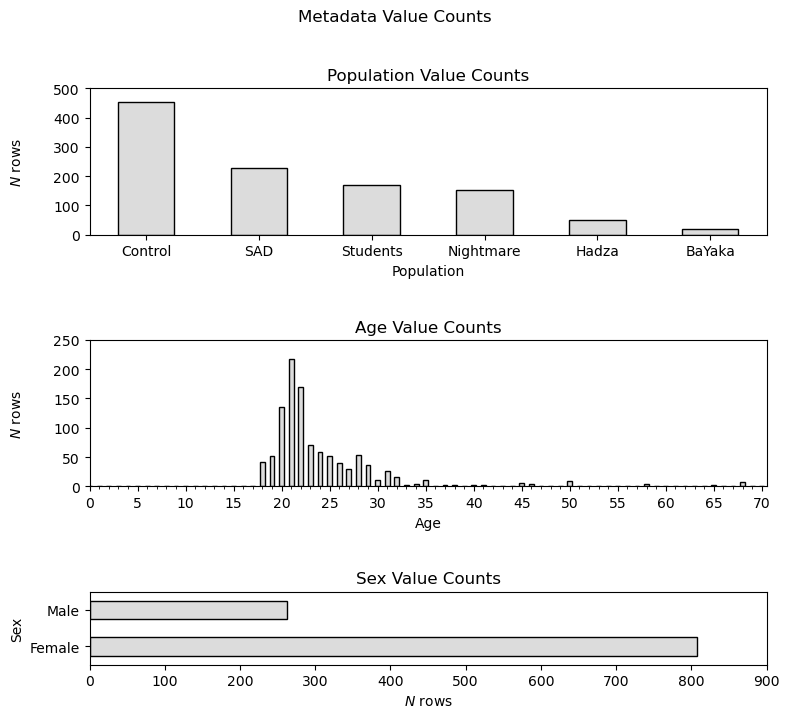

In [324]:
PLOT_KWARGS = {
    "color": "gainsboro",
    "edgecolor": "black",
}
fig, axes = plt.subplots(nrows=3, figsize=(8, 7), gridspec_kw={"height_ratios": [2, 2, 1]})

df["Population"].value_counts(dropna=False).plot(
    kind="bar", ylabel=r"$N$ rows", title="Population Value Counts", ax=axes[0], **PLOT_KWARGS
)
axes[0].tick_params(axis="x", labelrotation="auto")
axes[0].set_ybound(upper=500)

assert df["Age"].dtype == int, "Age column is expected to be of integer type"
(
    df["Age"]
    .value_counts(dropna=False)
    .reindex(range(0, df["Age"].max() + 1))
    .fillna(0)
    .astype(int)
    .plot(
        kind="bar",
        title="Age Value Counts",
        xlabel="Age",
        ylabel=r"$N$ rows",
        ax=axes[1],
        **PLOT_KWARGS,
    )
)
axes[1].set_xbound(lower=0)
axes[1].set_ybound(upper=250)
axes[1].tick_params(axis="x", labelrotation="auto")
axes[1].xaxis.set_major_locator(plt.MultipleLocator(5))
axes[1].xaxis.set_minor_locator(plt.MultipleLocator(1))

df["Sex"].value_counts(dropna=False).plot(
    kind="barh", title="Sex Value Counts", xlabel=r"$N$ rows", ax=axes[2], **PLOT_KWARGS
)
axes[2].set_xbound(upper=900)

fig.suptitle("Metadata Value Counts", y=1.02)
fig.align_ylabels(axes)
fig.tight_layout(h_pad=3)

### Metadata reduction

Reduce, clean, and validate metadata

Perform small modifications such as reducing columns, renaming columns, and renaming column values.

The goal is to have all columns and categorical string columns represented with strings that are all lowercase and snake_case.

_This section would include converting things like txt files to a DataFrame._

Reduce columns

Drop the `Number` and LIWC output columns as they are derived data.

In [204]:
df = df.drop(columns=DERIVED_COLUMNS)
display(df.head(n=5))

,ID,Population,Age,Sex,Dream
0,1,Hadza,46,Male,I was an antelope in a stony landscape with brush. I was not hunting in it. I only saw it and it ran away when I saw it.
1,1,Hadza,46,Male,"I dreamt that theives came and were slaughtering a man. Then a few chaga men were attacking a Hadzabe man named Musa. I started to scream ""stop killing him, stop killing him,"" but the man was already dead."
2,1,Hadza,46,Male,"I dreamt a buffalo hit me. I was in Numbeya bushland where we look for honey. I was looking for the ""small honey."" There was another man called January and he came and helped me. I tried to run to climb the mountain to escape."
3,1,Hadza,46,Male,I dreamt I fell into a well that is near the Hukumako area by the Dtoga people. I was with two others and one of my friends helped me get out of the well. I know the mean who were with me.
4,2,Hadza,38,Female,I remember being chased by an elephant in a location around camp. I escaped.


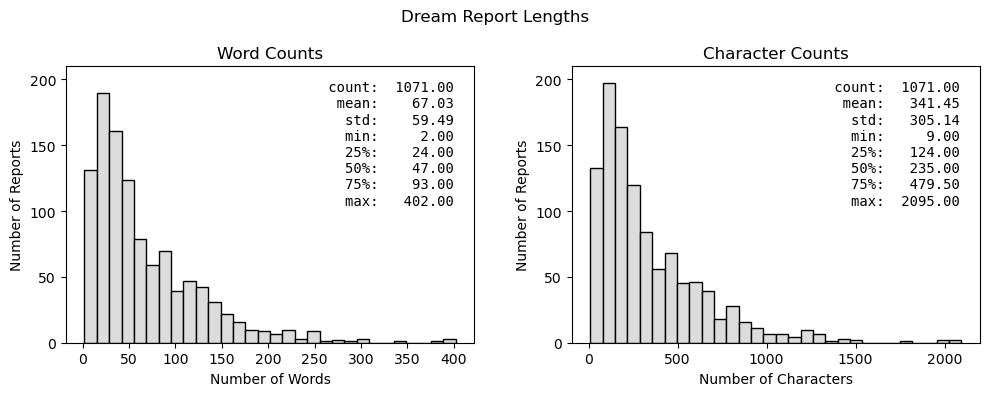

In [325]:
# Final view of word counts, maybe check for EXTREME long and short but not removing. I mean.
HIST_KWARGS = {"bins": 30, "color": "gainsboro", "edgecolor": "black"}
TEXT_KWARGS = {
    "verticalalignment": "top",
    "horizontalalignment": "right",
    "fontdict": dict(family="monospace"),
    "bbox": dict(facecolor="white", edgecolor="none"),
}
word_counts = df[REPORT_COL].str.split().str.len()
char_counts = df[REPORT_COL].str.len()
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
fig.suptitle("Dream Report Lengths")
axes[0].hist(word_counts, **HIST_KWARGS)
axes[1].hist(char_counts, **HIST_KWARGS)
axes[0].set(title="Word Counts", xlabel="Number of Words", ylabel="Number of Reports")
axes[1].set(title="Character Counts", xlabel="Number of Characters", ylabel="Number of Reports")

word_stats = word_counts.describe()
char_stats = char_counts.describe()
word_stats_text = "\n".join([f"{stat + ":":>12} {val:>8.2f}" for stat, val in word_stats.items()])
char_stats_text = "\n".join([f"{stat + ":":>12} {val:>8.2f}" for stat, val in char_stats.items()])
axes[0].text(0.95, 0.95, word_stats_text, transform=axes[0].transAxes, **TEXT_KWARGS)
axes[1].text(0.95, 0.95, char_stats_text, transform=axes[1].transAxes, **TEXT_KWARGS)

axes[0].yaxis.set_major_locator(plt.MultipleLocator(50))
axes[0].set_ybound(upper=210)
axes[1].tick_params(labelleft=True)

fig.tight_layout(w_pad=3)

In [331]:
# Inspect reports with extremely low word counts to verify they are sensible.
short_dreams = df[word_counts <= 5]
print(f"Number of dreams reports with 5 or less words: {len(short_dreams)}")
if not short_dreams.empty:
    display(short_dreams[[AUTHOR_COL, "Population", REPORT_COL]])

Number of dreams reports with 5 or less words: 23


,ID,Population,Dream
81,46,SAD,I was looking for something
243,72,SAD,very abstract dream
284,82,SAD,I remember seeing my mother
525,128,Nightmare,A party with friends
541,132,Nightmare,I was a house builder
594,140,Nightmare,feeling of fear
600,141,Nightmare,Anguish and despair felt
652,153,Control,Charlotte's birthday. Fight many weapons
653,153,Control,Lionel festival team
654,153,Control,Kevin's book


In [330]:
# Inspect reports with extremely high word counts to verify they are sensible.
long_dreams = df[word_counts >= 1000]
print(f"Number of dreams reports with 1000 or more words: {len(long_dreams)}")
if not long_dreams.empty:
    display(long_dreams[[AUTHOR_COL, "Population", REPORT_COL]])

Number of dreams reports with 1000 or more words: 0


### Dream report qualitative observations

Things noticed during processing and manual inspection.

In [ ]:
# Show how BaYaka dream reports have similar endings.
N_CHARS = 30
df_bayaka = (
    df
    .loc[df[REPORT_COL].str.len() > N_CHARS]
    .loc[df["Population"] == "BaYaka"]
    .copy()
)
col_name = REPORT_COL + f"-last{N_CHARS}chars"
df_bayaka[col_name] = df_bayaka[REPORT_COL].str[-N_CHARS:].radd("[...]")
df_bayaka = df_bayaka[[AUTHOR_COL, "Population", col_name]]
# Display the pandas dataframe with style added to make dream column monospace font
# df_bayaka = df_bayaka.style.set_properties(subset=[col_name], **{"font-family": "monospace"})

# def partial_highlight(val, substring):
#     # Use regex to find and wrap the substring in HTML tags
#     pattern = re.compile(f"({re.escape(substring)})", re.IGNORECASE)
#     return pattern.sub(r"<mark style='background-color: orange'>\1</mark>", str(val))
# # Use .format to change how the text is rendered
# df_bayaka = df_bayaka.style.format(lambda x: partial_highlight(x, "It was a good dream"))
phrases = [
    "It was a good dream",
    "It was a bad dream",
    "A very sad dream",
    "A good dream"
]

pattern_str = "(" + "|".join(p for p in phrases) + ")"
pattern = re.compile(pattern_str, re.IGNORECASE)
df_bayaka = (df_bayaka.style
    .format(lambda x: pattern.sub(r"<mark style='background-color: orange'>\1</mark>", str(x)))
    .set_properties(subset=[col_name], **{"font-family": "monospace"})
)
display(df_bayaka)

,ID,Population,Dream-last30chars
51,19,BaYaka,[...] animals. It was a good dream.
52,19,BaYaka,[...]full of water. It was a river.
53,20,BaYaka,[...] she gave birth to twin girls.
54,20,BaYaka,[...]t to push. It was a good dream
55,21,BaYaka,[...] ran away. It was a bad dream.
56,21,BaYaka,[...]cond wife. It was a bad dream.
57,21,BaYaka,[...]any fish. It was a good dream.
58,22,BaYaka,[...]any fish. It was a good dream.
59,24,BaYaka,[...]ath from thanry. A good dream.
60,26,BaYaka,[...]back to share with his family.


BaYaka dreams are the only ones written in <mark style="background-color: orange">third person</mark>. Others are in <mark style="background-color: green">first person</mark>.




In [458]:
# BaYaka dreams are the only ones written in third person.
# Could be a reporing style, but probably not since
# 1. they were translated
# 2. they are first-person when presented in the publication as examples
# Show a subset of dreams from all populations
# Show how BaYaka dream reports have similar endings.
N_CHARS = 30
# Get 10 random samples from each population
N_PER_POP = 5
# df_pops = (
#     df[df[REPORT_COL].str.len() > N_CHARS]
#     .sample(frac=1, random_state=42).groupby("Population").head(N_PER_POP).sort_index()
# )
# Take the first 5 reports from each population,
# avoiding duplicates from same authors
# avoiding those with low character counts
df_pops = (
    df[df[REPORT_COL].str.len() > N_CHARS]
    .drop_duplicates(subset=AUTHOR_COL)
    .groupby("Population", group_keys=False)
    .head(N_PER_POP)
)
col_name = REPORT_COL + f"-first{N_CHARS}chars"
df_pops[col_name] = df_pops[REPORT_COL].str[:N_CHARS].add("[...]")
df_pops = df_pops[[AUTHOR_COL, "Population", col_name]]
# Display the pandas dataframe with style added to make dream column monospace font
# df_bayaka = df_bayaka.style.set_properties(subset=[col_name], **{"font-family": "monospace"})

first_person_phrases = [
    r"\bI\'m\b",
    r"\bI\b",
    r"\b[Mm]y\b",
    r"\bme\b",
]
third_person_phrases = [
    r"\bhe\b",
    r"\bshe\b",
    r"\bhis\b",
    r"\bher\b",
    r"\bhers\b",
]
first_person_phrases_pattern_str = "(" + "|".join(p for p in first_person_phrases) + ")"
third_person_phrases_pattern_str = "(" + "|".join(p for p in third_person_phrases) + ")"
first_person_phrases_pattern = re.compile(first_person_phrases_pattern_str, re.IGNORECASE)
third_person_phrases_pattern = re.compile(third_person_phrases_pattern_str, re.IGNORECASE)
def apply_all_highlights(val):
    text = str(val)
    # Apply first replacement (Green)
    text = third_person_phrases_pattern.sub(
        r"<mark style='background-color: orange'>\1</mark>", text
    )
    # Apply second replacement (Orange) onto the already modified text
    text = first_person_phrases_pattern.sub(
        r"<mark style='background-color: green'>\1</mark>", text
    )
    return text
df_pops = (df_pops.style
    .format(apply_all_highlights)
    .set_properties(subset=[col_name], **{"font-family": "monospace"})
)
display(df_pops)

,ID,Population,Dream-first30chars
0,1,Hadza,I was an antelope in a stony l[...]
4,2,Hadza,I remember being chased by an [...]
6,3,Hadza,I went to dig alone and when I[...]
7,4,Hadza,I dreamt I was chased by an el[...]
8,5,Hadza,I dreamt I was taken by an ele[...]
51,19,BaYaka,Last night dreamt his mother w[...]
53,20,BaYaka,Dreamt she gave birth to twin [...]
55,21,BaYaka,Dreamt a Bantu man was beating[...]
58,22,BaYaka,"Dreamt she was bail-fishing, a[...]"
59,24,BaYaka,Dreamt bosolo and moshimo (her[...]


In [ ]:
# Some dreams are multiple dreams in one report.
# Let's highlight those segments.
PHRASES = [
    "In another dream",
]
# Find and display dreams with these phrases
multi_dreams_mask = df[REPORT_COL].str.contains(
    "|".join(re.escape(phrase) for phrase in PHRASES),
    regex=True,
    case=False,
    na=False,
)
multi_dreams = df[multi_dreams_mask]
print(f"Number of dream reports with multiple dreams indicated: {len(multi_dreams)}")
if not multi_dreams.empty:
    # Highlight the phrases in the report text
    pattern_str = "(" + "|".join(re.escape(p) for p in PHRASES) + ")"
    pattern = re.compile(pattern_str, re.IGNORECASE)
    def highlight_phrases(text):
        return pattern.sub(r"<mark style='background-color: yellow'>\g<0></mark>", str(text))
    multi_dreams = (multi_dreams[[AUTHOR_COL, "Population", REPORT_COL]].style
        .format({REPORT_COL: highlight_phrases})
        .set_properties(subset=[REPORT_COL], **{"font-family": "monospace"})
    )
    display(multi_dreams)

Number of dream reports with multiple dreams indicated: 5


,ID,Population,Dream
105,51,SAD,"In another dream I was with a friend named Phil who is 31 years old [we haven't spoken in a long time, I called him a month ago to check in] also had his girlfriend, we were getting ready to go camping, with our bikes and our things in backpacks. Phil had a very nice and electric bike and special bags to store his things that folded. We were in a place a bit like Burning Man, in a desert."
302,86,Students,"I was walking in my home town, close to the beach. Someone from my childhood came to walk with me. He was making me uncomfortable. I saw my friend at the beach with her friends and saw it as a good excuse to get away from him. I stayed with her a while, I remember she smelled good. Then I slipped out so no one could see my leave. As a walked through my town I went into a store that had many pictures of a famous person I like. I exchanged text messages with them because apparently we knew each other. Then my friend (or mom, not sure) and I went inside someone's yard because we wanted lemons. The owner of the house caught us and we tried to jump her yard's wall. When I got to the top realized there was no way of getting down on the other side. Her dogs were barking at me so I gave in. In another dream I was with my godmother, her son and daughter-in-law. My family was also there. We just walked around the house and hung out."
357,92,Students,"I found a little white dog (the location was unknown to me) and rescued it. It didn't want to get caught, but eventually when it was in my hands it slowly trusted me and became more relaxed. I could tell it was old and probably injured, so I was very gentle with it. He started to sleep in my arms as I carried him home (unfamiliar home). We sat together until I could get him to the vet (my regular vet in Ancaster). I felt worried, but confident he'd recover. In another dream that night, I was building a modern house in Minecraft. I felt relaxed and I had fun."
398,98,Students,It was a weird night I had at least three different dreams I can recall. In one- my dad is making food and he is super grumpy about it. In the dream we are preparing a feast for my spouse who is about to arrive. In another dream I am losing teeth- now this is a very common and disturbing dream I get every now and then. Ever since I had braces I get this dream. Where my teeth are locked together and hurt a lot and as I try to open my mouth and separate my upper set from my lower set my teeth fall out. In this dream I had 3 teeth fall out in front of a room full of guests. I forgot my third dream in the time I took trying to write this.
789,190,Control,"It takes place in my elementary school, the places are identical to those in the past, except that the people are their current age. It's break time, all the people are gathered outside and we're grouped into small groups because there's been a murder in the playground and we have to solve the case. The corpse is covered with a sheet and there is blood all over the walls of the school. The atmosphere is tense and everyone gets angry because rumors say that the assassin is still on school grounds. Then this crime story disappears and we start playing volleyball. Then the bell rings, all the classes gather in rows in the same places as in the past. But in the row, an old childhood friend hits me, we start fighting on the floor, I realize it's my cousin but we keep fighting and at one point he turns into my current cat, but with blood all over the place, he limps away, jumps the low wall that surrounds the school, jumps into a passing car (a big car converted into a house that I'm sure I've seen in another dream that night). The car pulls away and the cat stares at me sadly. And I start crying because I know I won't see him again and I feel guilty for hitting him. (And during the whole last part there was a song that stuck in my head all morning but I couldn't put a title on it.)"


* Some reports imply they are supposed to be attached to the previous entry: "I also went surfing with my sister" (SAD)
    - "For the previous dream report: in between my family arriving and the airport, a classmate from high school ([20 female] who I last saw four years ago and are not close friends with) and her girlfriend ([20 female?]who I have never met) showed up at the condo complex and taught me how to dive in the river/sea running through the condos. In the dream I was uncomfortable to be with a stranger and nervous to dive. 
    
    My partner is 20, male. My parents are both 39, one male, one female. My cousin is 21, male. My grandfather is 62 (?), male. My family lives in Indonesia which is why it was unusual that they showed up in the dream's depiction of Canada."
    (Students)


In [398]:
# Some reports imply they are supposed to be attached to the previous entry
# Probably from dream diary studies
PHRASES = [
    "I also went surfing with my sister",
    "For the previous dream report:",
]
# Find and display dreams with these phrases
tackon_mask = df[REPORT_COL].str.contains(
    "|".join(re.escape(phrase) for phrase in PHRASES),
    regex=True,
    case=False,
    na=False,
)
tackons = df[tackon_mask]
print(f"Number of dream reports that appear to be tackons: {len(tackons)}")
if not tackons.empty:
    # Highlight the phrases in the report text
    pattern_str = "(" + "|".join(re.escape(p) for p in PHRASES) + ")"
    pattern = re.compile(pattern_str, re.IGNORECASE)
    def highlight_phrases(text):
        return pattern.sub(r"<mark style='background-color: yellow'>\g<0></mark>", str(text))
    tackons = (tackons[[AUTHOR_COL, "Population", REPORT_COL]].style
        .format({REPORT_COL: highlight_phrases})
        .set_properties(subset=[REPORT_COL], **{"font-family": "monospace"})
    )
    display(tackons)
    

Number of dream reports that appear to be tackons: 2


,ID,Population,Dream
235,69,SAD,I also went surfing with my sister
402,99,Students,"For the previous dream report: in between my family arriving and the airport, a classmate from high school ([20 female] who I last saw four years ago and are not close friends with) and her girlfriend ([20 female?]who I have never met) showed up at the condo complex and taught me how to dive in the river/sea running through the condos. In the dream I was uncomfortable to be with a stranger and nervous to dive. My partner is 20, male. My parents are both 39, one male, one female. My cousin is 21, male. My grandfather is 62 (?), male. My family lives in Indonesia which is why it was unusual that they showed up in the dream's depiction of Canada."


In [397]:
# Some dreams are no dream at all. Let's highlight those segments.
# Presumably from dream diary studies
PHRASES = [
    "I don't remember",
]
# Find and display dreams with these phrases
no_dream_mask = df[REPORT_COL].str.contains(
    "|".join(re.escape(phrase) for phrase in PHRASES),
    regex=True,
    case=False,
    na=False,
)
no_dreams = df[no_dream_mask]
print(f"Number of dream reports with multiple dreams indicated: {len(no_dreams)}")
if not no_dreams.empty:
    # Highlight the phrases in the report text
    pattern_str = "(" + "|".join(re.escape(p) for p in PHRASES) + ")"
    pattern = re.compile(pattern_str, re.IGNORECASE)
    def highlight_phrases(text):
        return pattern.sub(r"<mark style='background-color: yellow'>\g<0></mark>", str(text))
    no_dreams = (no_dreams[[AUTHOR_COL, "Population", REPORT_COL]].style
        .format({REPORT_COL: highlight_phrases})
        .set_properties(subset=[REPORT_COL], **{"font-family": "monospace"})
    )
    display(no_dreams)
    

Number of dream reports with multiple dreams indicated: 57


,ID,Population,Dream
110,53,SAD,"This dream was clear when I ""lived"" it, but I only remember small bits. * It was my birthday and there were my friends [I couldn't see their clothes] and other friends but family. I think there were cakes, but I don't remember what. * At one point my mother was angry and said of a small child that he or she [can't remember] was badly brought up. * At one point, someone had just climbed into our attic (I was afraid in this part of the dream because the person was dangerous) into our attic. My mother and I were in my room (the attic and above). I remember telling him to whisper because he could hear us. [It seems to me that the person in the attic was dangerous]. In this dream everything happened in my house, nothing changed me compared to reality, apart from the hatch to go to the attic which was in my room instead of being in the hallway."
111,53,SAD,"In this dream, we were first sitting outside with the guests. Suddenly, our living room has turned into a sort of concert hall with a stage that can go up and down. I wanted to sing but my (my mother's reaction made me sad and angry) mother yelled at me something. [I don't remember what it is, but it's true that even if I want to, I don't sing in front of others because I'm afraid someone will say something to me]. He was a little boy who started to sing [he sang well]. Everyone was happy. In the living room, at that time, the lights were blue, a bit like in concert halls. The boy was brown."
112,53,SAD,"In this dream we are in an amphitheater at uni. It seems to me. There are students and their parents (only mothers). I'm at the very top [I usually put myself at the bottom] and my mother is lower on the right. I don't know the teacher at all [he has no face in my dream]. It's actually a lesson on insects. I don't remember the course at all. At the end the teacher asked us which insect could build something between two wooden posts. I proposed the hornet [although I have never participated in a course]. But the teacher replied that it was the spider that can indeed weave webs. In this dream I don't know anyone except my mother and the mother of a student. Everyone was talking, there was a lot of noise. I was a little interesting [I was like that in primary, but something has changed since]"
113,53,SAD,"This dream, it seems to me, follows on from the second, but I didn't see any parents there and there were a lot fewer students. This time, I had many friends of mine. This dream was actually a kind of race. You had to be the first team to finish showering. The showers were like cabins in swimming pools. I remember we were talking but I don't remember what. The atmosphere was rather friendly, joyful."
124,54,SAD,"I was with my sister. She is 17 years old. We just talked yesterday on a video call. We were prisoners in a kind of giant factory. We had to find the missing part of the object to be able to get out of this place. The object in question was some kind of toy or a figurine of an animal, but I don't remember which. The missing part was a kind of accessory tool of this animal figurine. The overall mood of the dream was creepy and I felt more like I was in a thriller movie. The people who imprisoned us were trying to prevent us from finding the object that would give us our freedom. I don't know these people."
125,54,SAD,In the first dream I was in the house with my grandparents in Colombia. It was the end of the day and I was with someone I didn't know before. I can't remember if it was a man or a woman. I know this person was young. In the dream we had to escape from someone who was trying to catch us. We tried to hide from this person both inside the house and in the garden. Towards the end of this dream we were even more afraid because this person who wanted to catch us wanted to burn down the house so that we could no longer hide inside. I don't remember the end of this dream.
153,56,SAD,"I went to my best friend's house and we played a ca

## Tidy-up (final)

Final cleaning and checks.

#### Cleaning

Final cleaning (mostly actions that are inconsequential for values but benefit readability).

In [207]:
# Sort values for easier viewing
# df = df.sort_values(["author", "condition", "prompt"])
# Reset index for clarity even though the index won't be included in the export
# This is important for later comparison too
df = df.reset_index(drop=True)

#### Quality confirmation

Now that all edits are done, ensure that the final dataset follows all expected rules.

In [208]:
# Re-run previous checks in case they got reintroduced between steps.
# or use pandera here?
assert (df[REPORT_COL] == df[REPORT_COL].str.strip()).all(), "Surrounding whitespace was reintroduced."
assert df.notna().all(axis=None), "Make sure there are no empty cells"
assert df[REPORT_COL].map(len).gt(0).all(axis=None), "Make sure there are no empty strings"
# assert df[AUTHOR_COL].is_unique, "Make sure all authors are unique"
assert df[REPORT_COL].is_unique, "Make sure all texts are unique"
assert not df.duplicated(subset=REPORT_COL).any(), "Make sure there are no duplicate reports"
# assert not df.duplicated().any(), "Make sure there are no duplicate rows"
# Make sure all texts are longer/shorter than expected

## Export

#### Write to file

Save final DataFrame as TSV file with LZMA compression.

In [209]:
OUTPATH = "output/samson2023.csv"
os.makedirs("output", exist_ok=True)
df.to_csv(
    path_or_buf=OUTPATH,
    index=False,
    sep=",",
    mode="x",
    encoding="utf-8-sig",
    lineterminator="\n",
    quoting=QUOTE_NONNUMERIC,
    quotechar='"',
    doublequote=True,
)

FileExistsError: [Errno 17] File exists: 'output/samson2023.csv'

#### Print file details

Print details for later viewing and copying to `raw/README.md` file.

In [ ]:
print("file:", os.path.basename(OUTPATH))
print("size:", os.path.getsize(OUTPATH) / 1e6, "Mb")
print("md5:", pooch.file_hash(OUTPATH, alg="md5"))
print("sha256:", pooch.file_hash(OUTPATH, alg="sha256"))

#### Read new data back in

Read it back in to make sure it was not corrupted during output, and give it a final view.

In [ ]:
df_reloaded = pd.read_csv(OUTPATH)
assert df_reloaded.equals(df), "Reloaded dataframe should match original."
display(df_reloaded.head(n=5))

## Describe

Print and visualize quick checks and descriptors of the dataset. Be careful to **not** wander into full dataset descriptor territory. Cover things like:

* General size (how many entries, authors, conditions?)
* Text length (how many characters, words, sentences, paragraphs?)
* Character counts (how many letters, digits, punctuation, whitespace?)
* What is the longest character sequence without a whitespace?
* Are there major spelling errors?

### View as table

In [ ]:
# with pd.option_context("display.max_colwidth", None):
#     display(df)
display(df)

### View final dream report lengths

### View final metadata value counts

### View final dream report lengths by population

### View final word cloud (solo and by population)